In [128]:
import pandas as pd
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss, precision_score, recall_score, precision_recall_curve, auc

import matplotlib.pyplot as plt
import sys
from IPython.display import display
import numpy as np

import os

# Get the absolute path of the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

import scripts.processing as processing
from prettytable import PrettyTable

In [29]:
df = pd.read_csv("../data/submissions.csv")
eviction_df = processing.clean_for_eviction(df)
layoff_df = processing.clean_for_layoff(df)

In [51]:
eviction_df['truth'].unique()

array([0., 1.])

In [143]:
def compute_auc_pr(group):
    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(group['truth'], group['prediction'])
    
    # Calculate the area under the precision-recall curve
    auc_pr = auc(recall, precision)
    
    return pd.Series({'auc_pr': auc_pr})

# Define a function to calculate error metrics for each model
def compute_error_metrics(group, threshold=0.5):
    # Calculating Brier score and log loss
    brier_score = brier_score_loss(group['truth'], group['prediction'])
    logloss = log_loss(group['truth'], group['prediction'])
    
    # Converting probabilities to binary decisions
    binary_predictions = (group['prediction'] >= threshold).astype(int)
    
    # Calculating precision and recall
    precision = precision_score(group['truth'], binary_predictions, zero_division=0)
    recall = recall_score(group['truth'], binary_predictions)
    p, r, _ = precision_recall_curve(group['truth'], group['prediction'])
    auc_pr = auc(r, p)
    return pd.Series({
        'brier_score': brier_score,
        'log_loss': logloss,
        'precision': precision,
        'recall': recall,
        'auc_pr': auc_pr
    })

# Function to calculate custom calibration curve
def custom_calibration_curve(df, bins):
    temp_df = df.copy()
    temp_df.loc[:, 'bin'] = pd.cut(temp_df['prediction'], bins=bins, right=True, include_lowest=True)
    
    grouped = temp_df.groupby('bin', observed = False)
    calibration_data = grouped.agg(
        prob_pred=('prediction', 'mean'),
        frac_positives=('truth', 'mean'),
        count=('prediction', 'size')  # count the number of entries in each bin
    ).reset_index()
    
    return calibration_data



In [197]:
import pandas as pd
# Assuming the DataFrame is named "df"
distribution = eviction_df['truth'].value_counts()

distribution[1] / distribution[0]


0.06271376902813001

In [208]:
model = "lennyc"
bins = [0.0, 0.06, 1]
model_data = eviction_df[eviction_df['account'] == model]
calibration_data = custom_calibration_curve(model_data, bins)
table = PrettyTable()
table.field_names = ["Bin", "Count", "Pred. Prob.", "Frac. Positives"]
table.title = f"Model {model}"
for index, row in calibration_data.iterrows():
    table.add_row([row['bin'], row['count'], row['prob_pred'], row['frac_positives']])
print(table)

+--------------------------------------------------------------------+
|                            Model lennyc                            |
+----------------+-------+--------------------+----------------------+
|      Bin       | Count |    Pred. Prob.     |   Frac. Positives    |
+----------------+-------+--------------------+----------------------+
| (-0.001, 0.06] |  574  | 0.0550458716189234 | 0.05574912891986063  |
|  (0.06, 1.0]   |  529  | 0.0646551724166772 | 0.062381852551984876 |
+----------------+-------+--------------------+----------------------+


+----------------------------------------------------------------------+
|                            Model kouyang                             |
+----------------+-------+----------------------+----------------------+
|      Bin       | Count |     Pred. Prob.      |   Frac. Positives    |
+----------------+-------+----------------------+----------------------+
| (-0.001, 0.05] |  595  | 0.020485384873949578 | 0.013445378151260505 |
|  (0.05, 1.0]   |  508  | 0.10354931692913387  | 0.11220472440944881  |
+----------------+-------+----------------------+----------------------+


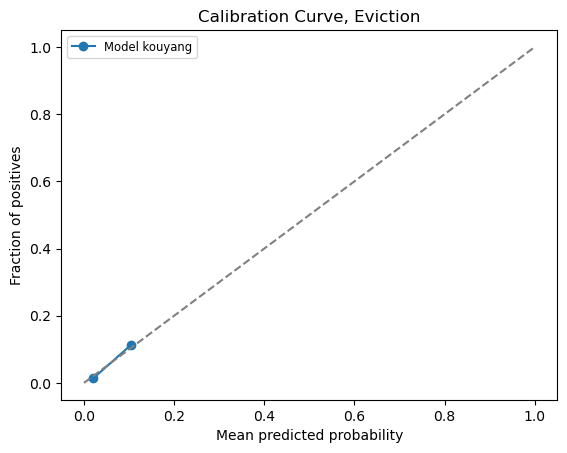

In [203]:
model = "kouyang"
# bins = [0.0, 0.1, 0.2, 0.3, 0.4, 1]
# bins = np.arange(0, 1.1, .1).tolist()
bins = [0.0, 0.05, 1]
model_data = eviction_df[eviction_df['account'] == model]
calibration_data = custom_calibration_curve(model_data, bins)
table = PrettyTable()
table.field_names = ["Bin", "Count", "Pred. Prob.", "Frac. Positives"]
table.title = f"Model {model}"
for index, row in calibration_data.iterrows():
    table.add_row([row['bin'], row['count'], row['prob_pred'], row['frac_positives']])
print(table)

fig, ax = plt.subplots()
ax.plot(calibration_data['prob_pred'], calibration_data['frac_positives'], marker='o', label=f'Model {model}')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration Curve, Eviction')
ax.legend(fontsize = 'small')

+---------------------------------------------------------------------+
|                            Model ADSgrp5                            |
+----------------+-------+----------------------+---------------------+
|      Bin       | Count |     Pred. Prob.      |   Frac. Positives   |
+----------------+-------+----------------------+---------------------+
| (-0.001, 0.03] |   0   |         nan          |         nan         |
|  (0.03, 0.2]   |  1103 | 0.059629882999999995 | 0.05893019038984588 |
|   (0.2, 0.4]   |   0   |         nan          |         nan         |
|   (0.4, 0.6]   |   0   |         nan          |         nan         |
|   (0.6, 0.8]   |   0   |         nan          |         nan         |
|   (0.8, 1.0]   |   0   |         nan          |         nan         |
+----------------+-------+----------------------+---------------------+
+-------------------------------------------------------------------+
|                         Model IU_Sociology                      

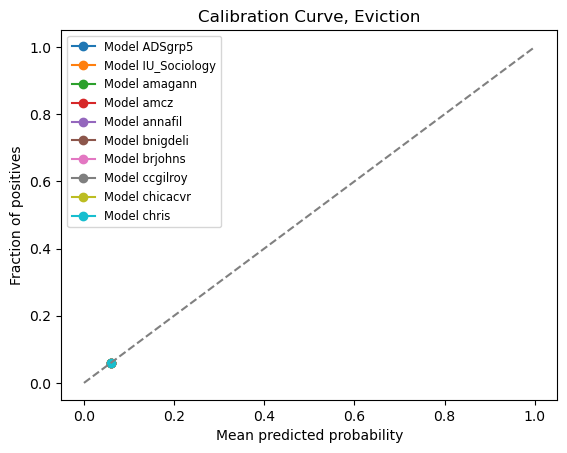

In [196]:
# Compute error metrics for each model
threshold = 0.05602
# metric = 'auc_pr'
# metric = 'precision'
metric = 'recall'
error_metrics = eviction_df.groupby('account', observed = False).apply(compute_error_metrics, threshold = threshold)

# Select top N models based on Brier score (or log_loss)
# top_models = error_metrics.nsmallest(10, 'brier_score').index

top_models = error_metrics.nlargest(10, metric).index

# bins = np.arange(0, 1.1, 0.1).tolist()

# bins = [0.0, 0.33, 0.67, 1]
# bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1]
bins = [0.0, 0.03, 0.2, 0.4, 0.6, 0.8, 1]

# Plot calibration curves for top models
fig, ax = plt.subplots()

for model in top_models:
    model_data = eviction_df[eviction_df['account'] == model]
    calibration_data = custom_calibration_curve(model_data, bins)
    ax.plot(calibration_data['prob_pred'], calibration_data['frac_positives'], marker='o', label=f'Model {model}')
    table = PrettyTable()
    table.field_names = ["Bin", "Count", "Pred. Prob.", "Frac. Positives"]
    table.title = f"Model {model}"
    for index, row in calibration_data.iterrows():
        table.add_row([row['bin'], row['count'], row['prob_pred'], row['frac_positives']])
    print(table)
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration Curve, Eviction')
ax.legend(fontsize = 'small')

plt.show()

In [ ]:


model = "bjgoode"
# bins = [0.0, 0.1, 0.2, 0.3, 0.4, 1]
# bins = np.arange(0, 1.1, .1).tolist()
bins = [0.0, 0.5, 1]
model_data = layoff_df[layoff_df['account'] == model]
calibration_data = custom_calibration_curve(model_data, bins)
table = PrettyTable()
table.field_names = ["Bin", "Count", "Pred. Prob.", "Frac. Positives"]
table.title = f"Model {model}"
for index, row in calibration_data.iterrows():
    table.add_row([row['bin'], row['count'], row['prob_pred'], row['frac_positives']])
print(table)

fig, ax = plt.subplots()
ax.plot(calibration_data['prob_pred'], calibration_data['frac_positives'], marker='o', label=f'Model {model}')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration Curve, Eviction')
ax.legend(fontsize = 'small')

+------------------------------------------------------------+
|                       Model ADSgrp5                        |
+----------------+-------+-------------+---------------------+
|      Bin       | Count | Pred. Prob. |   Frac. Positives   |
+----------------+-------+-------------+---------------------+
| (-0.001, 0.33] |  994  |  0.20908379 | 0.21227364185110664 |
|  (0.33, 0.67]  |   0   |     nan     |         nan         |
|  (0.67, 1.0]   |   0   |     nan     |         nan         |
+----------------+-------+-------------+---------------------+
+------------------------------------------------------------------+
|                        Model IU_Sociology                        |
+----------------+-------+-------------------+---------------------+
|      Bin       | Count |    Pred. Prob.    |   Frac. Positives   |
+----------------+-------+-------------------+---------------------+
| (-0.001, 0.33] |  994  | 0.209083790133125 | 0.21227364185110664 |
|  (0.33, 0.67]  | 

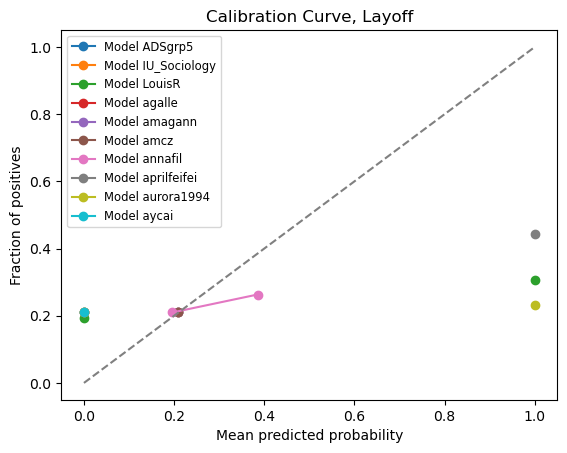

In [212]:
# Compute error metrics for each model
# threshold = 0.5
# metric = 'auc_pr'
# metric = 'precision'
# metric = 'recall'
error_metrics = eviction_df.groupby('account', observed = False).apply(compute_error_metrics, threshold = threshold)

# Select top N models based on Brier score (or log_loss)
top_models = error_metrics.nsmallest(10, 'brier_score').index

# top_models = error_metrics.nlargest(10, metric).index

# bins = np.arange(0, 1.1, 0.1).tolist()

bins = [0.0, 0.33, 0.67, 1]
# bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1]
# bins = [0.0, 0.03, 0.2, 0.4, 0.6, 0.8, 1]


# Plot calibration curves for top models
fig, ax = plt.subplots()

for model in top_models:
    model_data = layoff_df[layoff_df['account'] == model]
    calibration_data = custom_calibration_curve(model_data, bins)
    ax.plot(calibration_data['prob_pred'], calibration_data['frac_positives'], marker='o', label=f'Model {model}')
    table = PrettyTable()
    table.field_names = ["Bin", "Count", "Pred. Prob.", "Frac. Positives"]
    table.title = f"Model {model}"
    for index, row in calibration_data.iterrows():
        table.add_row([row['bin'], row['count'], row['prob_pred'], row['frac_positives']])
    print(table)
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration Curve, Layoff')
ax.legend(fontsize = 'small')

plt.show()

In [73]:
temp_df

,outcome,outcome_name,account,challengeID,prediction,truth,ybar_train,r2_holdout,beatingBaseline,bin
1010285,eviction,D. Eviction,wrcCOS424,2,0.0,0.0,0.05963,-5.392014,False,"[0.0, 0.05)"
1010286,eviction,D. Eviction,wrcCOS424,4,1.0,1.0,0.05963,-5.392014,False,NaN
1010287,eviction,D. Eviction,wrcCOS424,11,1.0,0.0,0.05963,-5.392014,False,NaN
1010288,eviction,D. Eviction,wrcCOS424,15,0.0,0.0,0.05963,-5.392014,False,"[0.0, 0.05)"
1010289,eviction,D. Eviction,wrcCOS424,17,1.0,0.0,0.05963,-5.392014,False,NaN
...,...,...,...,...,...,...,...,...,...,...
1011870,eviction,D. Eviction,wrcCOS424,4231,0.0,1.0,0.05963,-5.392014,False,"[0.0, 0.05)"
1011871,eviction,D. Eviction,wrcCOS424,4233,0.0,0.0,0.05963,-5.392014,False,"[0.0, 0.05)"
1011872,eviction,D. Eviction,wrcCOS424,4234,0.0,0.0,0.05963,-5.392014,False,"[0.0, 0.05)"
1011873,eviction,D. Eviction,wrcCOS424,4237,0.0,0.0,0.05963,-5.392014,False,"[0.0, 0.05)"
